In [1]:
from time import time, localtime
import numpy as np
from utils import plot_graph
import tensorflow_federated as tff
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras import losses, metrics, optimizers
import random
import pandas as pd
import sys
import matplotlib.pyplot as plt
import nest_asyncio
from pathlib import Path
from checkpoint_manager import FileCheckpointManager
import tensorflow_addons as tfa
nest_asyncio.apply()
SEED = 1337
tf.random.set_seed(SEED)


2022-11-29 00:48:05.871295: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 00:48:06.012013: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-29 00:48:06.012058: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-29 00:48:06.041837: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-29 00:48:09.217634: W tensorflow/stream_executor/pla

Lựa chọn model <br>
Thay models.<Ten_model>

In [2]:
from models.CNNv6 import create_keras_model


Thay đổi các siêu tham số trong cell dưới <br>
**experiment_name:** Tên bộ dữ liệu được sử dụng, <Tên dữ liệu>_<Số byte sử dụng> <br>
**method:** Mô hình sử dụng <br>
**client_lr, server_lr:** Learning rate của client và server, khi fine tune bắt đầu từ 1 và giảm dần xuống 3e-4 <br>
**NUM_ROUNDS:** Số vòng lặp (Bắt đầu từ 1 và tăng dần lên 3000 nếu mô hình chưa hội tụ - 1/100/200/300/400/500/.../3000) <Br>
**BATCH_SIZE:** Kích thước batch (Bắt đầu từ 8 và tăng dần lên 64) 8/16/32/64 <br>
**split:** Để nguyên là 5

byte_number (string): Cac byte cua packet, bao gom 10, 32, 64, 128, 256, 512, 1024, 1460

In [3]:
byte_number = "512"


In [4]:
experiment_name = "GQUIC_" + byte_number
method = "nonFL_CNNv6_W_FS"
client_lr = 3e-4
NUM_ROUNDS = 100
BATCH_SIZE = 16


In [5]:
this_dir = Path.cwd()
model_dir = this_dir / "sdn_saved_models" / experiment_name / method
output_dir = this_dir / "sdn_results" / experiment_name / method

if not model_dir.exists():
    model_dir.mkdir(parents=True)

if not output_dir.exists():
    output_dir.mkdir(parents=True)


In [6]:
def sec_to_hours(seconds):
    a = seconds//3600
    b = (seconds % 3600)//60
    c = (seconds % 3600) % 60
    d = "{:.0f} hours {:.0f} mins {:.0f} seconds".format(a, b, c)
    return d


In [7]:
def most_frequent(List):
    return max(set(List), key=List.count)


### Đọc dữ liệu

In [8]:
train_dir = '/home/onos/FL/Data_Processing/GQUIC_small/Train/GQUIC_data_' + byte_number + '.feather'
test_dir = '/home/onos/FL/Data_Processing/GQUIC_small/Test//GQUIC_test_' + byte_number + '.feather'
data = pd.read_feather(train_dir)
test = pd.read_feather(test_dir)


In [9]:
# data.drop(['length'],axis=1,inplace=True)
# test.drop(['length'],axis=1,inplace=True)


In [10]:
result = test.groupby('flow_id')['Label'].apply(list).to_dict()
flow_label = []
for flow in result:
    flow_label.append(most_frequent(result[flow]))

In [11]:
true_test = test.drop('flow_id', axis=1)
true_data = data.drop('flow_id', axis=1)

In [12]:
NUM_FEATURE = len(true_test.columns)-1
NUM_CLASSES = len(np.unique(true_test['Label']))
print(NUM_FEATURE, NUM_CLASSES)


512 4


In [13]:
y_test = true_test['Label'].to_numpy()
x_test = true_test.drop('Label', axis=1).to_numpy()
y_train = true_data['Label'].to_numpy()
x_train = true_data.drop(['Label'], axis=1).to_numpy()

In [14]:
# def sklearn_to_df(sklearn_dataset):
#     df = pd.DataFrame(sklearn_dataset.data,
#                       columns=sklearn_dataset.feature_names)
#     df['Label'] = pd.Series(sklearn_dataset.Label)
#     return df


In [15]:
# from sklearn import datasets
# df = sklearn_to_df(datasets.load_iris())


In [16]:
# train_data = train_data[0].concatenate(train_data[1])
# val_data = val_data[0].concatenate(val_data[1])


### Model Definition

In [17]:
model = create_keras_model(NUM_FEATURE, NUM_CLASSES)
model.summary()

2022-11-29 00:48:19.053558: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-29 00:48:19.053609: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-29 00:48:19.053633: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (onos-virtual-machine): /proc/driver/nvidia/version does not exist
2022-11-29 00:48:19.053948: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 512, 32)           64        
                                                                 
 dropout (Dropout)           (None, 512, 32)           0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 171, 32)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5472)              0         
                                                                 
 dense (Dense)               (None, 32)                175136    
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=client_lr), loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
start = time()
history = model.fit(x_train, y_train, epochs=NUM_ROUNDS, batch_size=BATCH_SIZE,use_multiprocessing=True,shuffle=False)
end = time() - start

Epoch 1/100


2022-11-29 00:48:20.130079: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 911114240 exceeds 10% of free system memory.


13903/13903 [==============================] - 55s 4ms/step - loss: 14.5114 - sparse_categorical_accuracy: 0.6448
Epoch 2/100
13903/13903 [==============================] - 53s 4ms/step - loss: 1.0110 - sparse_categorical_accuracy: 0.6264
Epoch 3/100
13903/13903 [==============================] - 53s 4ms/step - loss: 0.9348 - sparse_categorical_accuracy: 0.6373
Epoch 4/100
13903/13903 [==============================] - 53s 4ms/step - loss: 0.9151 - sparse_categorical_accuracy: 0.6423
Epoch 5/100
13903/13903 [==============================] - 57s 4ms/step - loss: 0.9151 - sparse_categorical_accuracy: 0.6393
Epoch 6/100
13903/13903 [==============================] - 87s 6ms/step - loss: 0.9091 - sparse_categorical_accuracy: 0.6400
Epoch 7/100
13903/13903 [==============================] - 87s 6ms/step - loss: 0.9013 - sparse_categorical_accuracy: 0.6423
Epoch 8/100
13903/13903 [==============================] - 89s 6ms/step - loss: 0.8961 - sparse_categorical_accuracy: 0.6452
Epoch 9/100

In [19]:
total_time = "Time: {}".format(sec_to_hours(end))
print(total_time)


Time: 2 hours 27 mins 15 seconds


### Evaluation

In [20]:
best_model_accuracy = history.history['sparse_categorical_accuracy'][np.argmin(history.history['loss'])]

In [21]:
_, test_acc = model.evaluate(x_test, y_test,verbose=2, batch_size=BATCH_SIZE,use_multiprocessing=True)

3475/3475 - 7s - loss: 8.6295 - sparse_categorical_accuracy: 0.1568 - 7s/epoch - 2ms/step


In [22]:
train_val = str(round(best_model_accuracy*100)) + "_" + str(round(test_acc*100))

In [23]:
this_dir = Path.cwd()
model_dir = this_dir / "sdn_saved_models" / experiment_name / method / train_val
output_dir = this_dir / "sdn_results" / experiment_name / method / train_val

if not model_dir.exists():
    model_dir.mkdir(parents=True)

if not output_dir.exists():
    output_dir.mkdir(parents=True)

In [24]:
model.save(model_dir/'model.h5')

In [25]:
with open(output_dir/'parameters.txt', 'w') as f:
    print('client_lr: {}\nEpochs: {}\nBATCH_SIZE: {}'.format(
        client_lr, NUM_ROUNDS, BATCH_SIZE), file=f)
    f.close()

In [26]:
text_file = open(output_dir/"time.txt", "w")
n = text_file.write(total_time)
text_file.close()

In [27]:
predictions = model.predict(x_test,verbose=2,use_multiprocessing=True,batch_size=BATCH_SIZE)

3475/3475 - 7s - 7s/epoch - 2ms/step


In [28]:
y_pred = np.argmax(predictions, axis=-1)
test['pred'] = y_pred.tolist()

In [29]:
result = test.groupby('flow_id')['pred'].apply(list).to_dict()
flow_pred = []
for flow in result:
    flow_pred.append(most_frequent(result[flow]))

In [30]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


classes = []
for c in range(NUM_CLASSES):
    classes.append("Class {}".format(c))
print(classes)
with open(output_dir/'metrics.txt', 'w') as f:
    confusion = confusion_matrix(flow_label, flow_pred)
    print('Confusion Matrix\n', file=f)
    print(confusion, file=f)

    # importing accuracy_score, precision_score, recall_score, f1_score
    print('\nAccuracy: {:.2f}\n'.format(
        accuracy_score(flow_label, flow_pred)), file=f)

    print('Micro Precision: {:.2f}'.format(
        precision_score(flow_label, flow_pred, average='micro')), file=f)
    print('Micro Recall: {:.2f}'.format(
        recall_score(flow_label, flow_pred, average='micro')), file=f)
    print(
        'Micro F1-score: {:.2f}\n'.format(f1_score(flow_label, flow_pred, average='micro')), file=f)

    print('Macro Precision: {:.2f}'.format(
        precision_score(flow_label, flow_pred, average='macro')), file=f)
    print('Macro Recall: {:.2f}'.format(
        recall_score(flow_label, flow_pred, average='macro')), file=f)
    print(
        'Macro F1-score: {:.2f}\n'.format(f1_score(flow_label, flow_pred, average='macro')), file=f)

    print('Weighted Precision: {:.2f}'.format(
        precision_score(flow_label, flow_pred, average='weighted')), file=f)
    print('Weighted Recall: {:.2f}'.format(
        recall_score(flow_label, flow_pred, average='weighted')), file=f)
    print(
        'Weighted F1-score: {:.2f}'.format(f1_score(flow_label, flow_pred, average='weighted')), file=f)

    print('\nClassification Report\n', file=f)
    print(classification_report(flow_label, flow_pred, target_names=classes), file=f)
    f.close()


['Class 0', 'Class 1', 'Class 2', 'Class 3']


/home/onos/FL/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onos/FL/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onos/FL/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/onos/FL/venv/lib/python3.9/site-packages/sklearn/metrics/_class

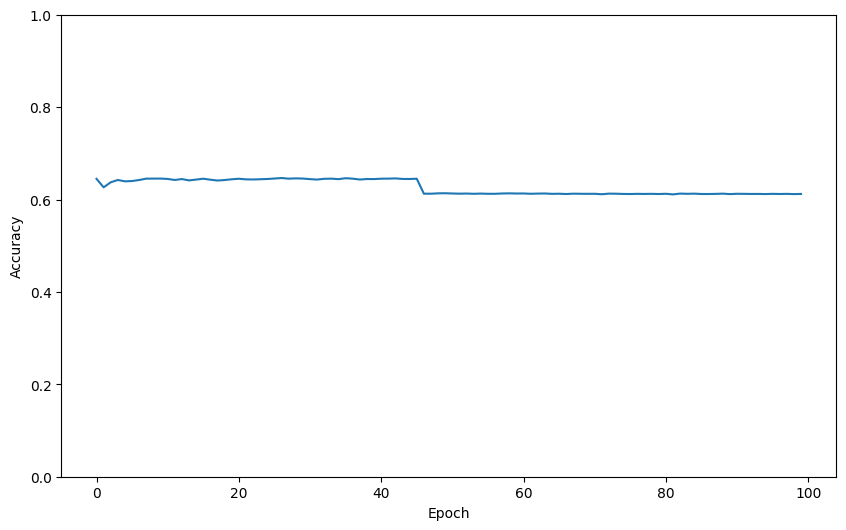

In [31]:
fig = plt.figure(figsize=(10, 6))
plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.savefig(output_dir / "normal_model_Accuracy.png")